# PS Dispersion measurement + wirescanner

Data on 2018.10.02 **not good**, the frequency was not changed due to an hardcoded wrong PLS user.

Still checking if the WS was triggered correctly at the end



In [54]:
# Quick fix for the usual Swan problems...
%run myToolbox.py

Version 0.03. This is the latest version.
Please help me to improve it reporting bugs to guido.sterbini@cern.ch.
Your platform is Linux-3.10.0-693.11.6.el7.x86_64-x86_64-with-redhat-6.10-Carbon
Your folder is /eos/user/e/esenes/Emittance-accuracy-measurement
Your IP is 172.17.0.27
2018-10-12 14:47:06


In [55]:
# %run /eos/project/l/liu/Toolbox/myToolbox.py
print '---'
%run /eos/user/e/esenes/PS-analysis-tools/eTools.py
print '---'

---
Version 0.1
Use at your own risk. Please report bugs to eugenio.senes@cern.ch
Fork it at https://gitlab.cern.ch/esenes/PS-analysis-tools
---


# User inputs

In [57]:
folderPath = '/eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.10.02_dispersion/'

matlabVars = ['PR_SCBFC.Samples.value.samples',
                'PR_BPM.AcquisitionOrbit.value.position', # BPMs
                'PR_BPM.AcquisitionTrajectoryBBB.value.position',
                'PR_BPM.AcquisitionMean.value.position',
                'PR_BCT_ST.Samples.value.samples',
                'PA_FREVCL_SD.Samples.value.samples', # Frequency sampler
                'PR_BWS_65_H_ROT.Acquisition.value.projDataSet1', # Wirescanner 85
                'PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1',
                'PR_BWS_65_H_ROT.Acquisition.value.acqTimeInCycleSet1'
            ]

In [58]:
# let's start with the matlab data
files = sorted(glob.glob(folderPath+'/data/2018*.mat'))#[:200]
print 'Found ' + str(len(files)) + ' data files'
print 'First: ' + files[0]
print 'End: ' + files[-1]

Found 300 data files
First: /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.10.02_dispersion//data/2018.10.02.21.27.58.274.mat
End: /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.10.02_dispersion//data/2018.10.03.01.29.36.590.mat


In [59]:
myDataFrame = myToolbox.fromMatlabToDataFrame(files,matlabVars,verbose=False)

# Data cleanup

In [60]:
myDataFrame = checkDuplicates(myDataFrame) # Drop double acquisitions from matlab
myDataFrame = checkBPMData(myDataFrame) # BPMs fault
# manual data drop
# myDataFrame = myDataFrame.drop(myDataFrame.loc['2018-09-21 19:34:43.900000'].name) # X wirescanner fault

Dropped 5 duplicate(s)
---
BPM data ok
---


# Save the imported data

In [61]:
myDataFrame.to_pickle('imported_data_2018.10.02.pkl')

In [62]:
# myDataFrame=pnd.read_pickle('imported_data_2018.09.21.pkl')

# Intensity

In [63]:
myDataFrame['Intensity'] = myDataFrame['PR_BCT_ST.Samples.value.samples']
myDataFrame['Intensity_max'] = [np.max(x) for x in myDataFrame['Intensity']]
myDataFrame['Losses'] = myDataFrame['Intensity'].apply(lambda x: 1-x[:][900]/x[:][500] )

Text(0,0.5,u'Losses')

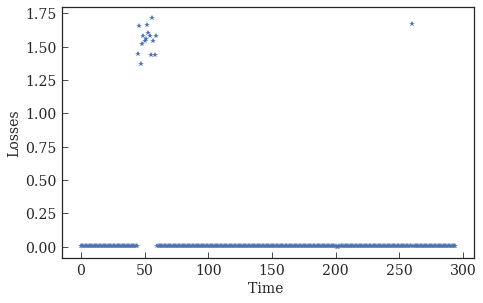

In [64]:
plt.plot(np.linspace(0,len(myDataFrame)-1,len(myDataFrame)),myDataFrame['Losses'],'*')
x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,0,0.05))
plt.xlabel('Time ')
plt.ylabel('Losses')

(0, 1000)

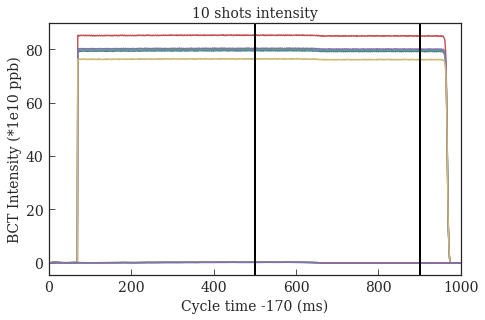

In [65]:
for ll in 40+np.array(range(10)):
    plt.plot(myDataFrame['Intensity'].values[ll])
    
plt.axvline(x=500, ymin=0, ymax = 8, linewidth=2, color='k')
plt.axvline(x=900, ymin=0, ymax = 8, linewidth=2, color='k')
plt.xlabel('Cycle time -170 (ms)')
plt.ylabel('BCT Intensity (*1e10 ppb)')
plt.title('10 shots intensity')
plt.xlim(0,1000)

In [66]:
# drop shots with losses (I still suspect it's just BCT fault)
myDataFrame = myDataFrame.drop(myDataFrame.loc[myDataFrame['Losses'] > 1].index)

# Calculate dp/p

from the formula 
$$
\frac{dp}{p} = -\frac{1}{\eta}\frac{f - f_0}{f_0}
$$

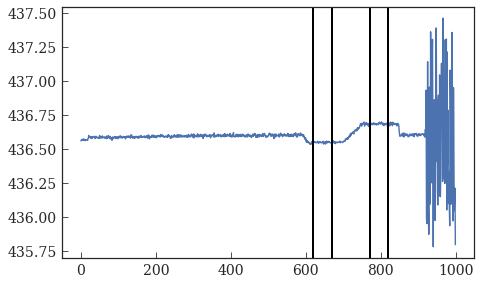

In [75]:
plt.plot(myDataFrame['PA_FREVCL_SD.Samples.value.samples'].iloc[0][:1000])
# f0 averaging interval
plt.axvline(x=620, ymin=0, ymax = 8, linewidth=2, color='k')
plt.axvline(x=670, ymin=0, ymax = 8, linewidth=2, color='k')
# f averaging interval
plt.axvline(x=770, ymin=0, ymax = 8, linewidth=2, color='k')
plt.axvline(x=820, ymin=0, ymax = 8, linewidth=2, color='k')

In [76]:
def dpp(f, f0):
    eta = -0.1340054072# from MADx injection7 tunes .21/.24
    return (-1/eta)*(f-f0)/f0

myDataFrame['f0'] = myDataFrame['PA_FREVCL_SD.Samples.value.samples'].apply(lambda x: np.mean(x[620:670]))
myDataFrame['f'] = myDataFrame['PA_FREVCL_SD.Samples.value.samples'].apply(lambda x: np.mean(x[770:820]))
myDataFrame['dpp'] = myDataFrame.apply( lambda row: dpp(row['f'], row['f0']), axis=1)

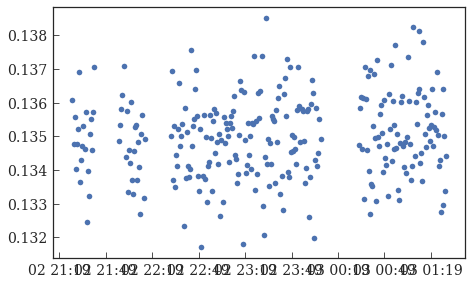

In [77]:
plt.plot(myDataFrame['f']-myDataFrame['f0'],'o')

## Average position at the BPM (in m)

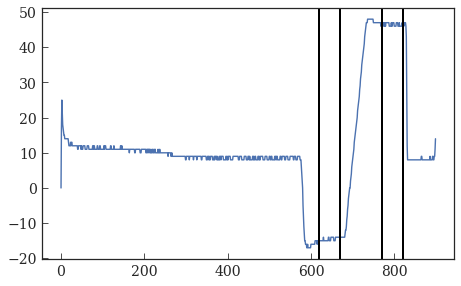

In [28]:
plt.plot(myDataFrame['PR_BPM.AcquisitionOrbit.value.position'].iloc[0][0,0:900])
# averaging interval
plt.axvline(x=770, ymin=0, ymax = 8, linewidth=2, color='k')
plt.axvline(x=820, ymin=0, ymax = 8, linewidth=2, color='k')
plt.axvline(x=620, ymin=0, ymax = 8, linewidth=2, color='k')
plt.axvline(x=670, ymin=0, ymax = 8, linewidth=2, color='k')


In [29]:
myDataFrame['x_bpms_mean'] = myDataFrame['PR_BPM.AcquisitionOrbit.value.position'].apply( lambda x: 1e-4*(np.mean(x[:,770:820]-np.mean(x[:,620:670]), axis=1)) )


# Fit the dispersion

In [30]:
from scipy.optimize import curve_fit
def lin(x, a, b):
    return a + b*x

D = []
s_D = []

BPMn = 43
xdata = myDataFrame['dpp']
for k in range(BPMn):
    ydata = myDataFrame['x_bpms_mean'].apply(lambda x: x[k])
    popt, pcov = curve_fit(lin, xdata, ydata )
    D.append(popt[1])
    s_D.append(pcov[1][1])
    
    
D = np.array(D, dtype=float)
s_D = np.array(s_D, dtype=float)

Text(0,0.5,u'D_x (m)')

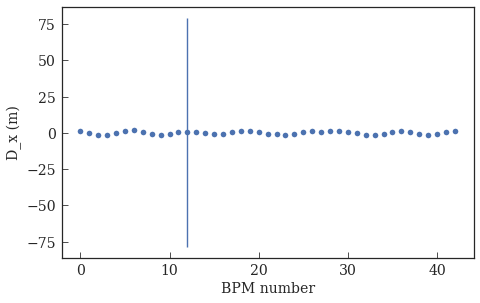

In [31]:
plt.errorbar(np.linspace(0,42,43), D, yerr=s_D, fmt='o')
plt.xlabel('BPM number')
plt.ylabel('D_x (m)' )

# Model-measurement comparison

In [32]:
optics = metaclass.twiss('/eos/user/e/esenes/Emittance-accuracy-measurement/MADx_PFW/madx/ps_6.21_6.24.twiss')
# get the twiss at the BPMs position
optics_names = optics.NAME
BPM_name = []
BPM_idx = []
BPM_Dx = []
BPM_Dy = []

for k in range(len(optics_names)):
    if optics_names[k].find('PR.BPM') != -1:
#        print optics_names[k]
        BPM_name.append(optics_names[k])
        BPM_idx.append(k)
        BPM_Dx.append(optics.DISP1[k])   
        BPM_Dy.append(optics.DISP3[k])

newBPM =  [BPM_name[-1]] + BPM_name[:-1]
BPM_name = newBPM

newBPM =  [BPM_Dx[-1]] + BPM_Dx[:-1]
BPM_Dx = newBPM
        
BPM_S = optics.S[BPM_idx]

In [34]:
print(BPM_name)
print(BPM_name[28])
print(BPM_Dx[30])
print(D[28])

print(BPM_name[30])
print(BPM_Dx[30])
print(D[30])

['PR.BPM00', 'PR.BPM03', 'PR.BPM05', 'PR.BPM07', 'PR.BPM10', 'PR.BPM13', 'PR.BPM15', 'PR.BPM17', 'PR.BPM20', 'PR.BPM23', 'PR.BPM25', 'PR.BPM27', 'PR.BPM30', 'PR.BPM33', 'PR.BPM35', 'PR.BPM37', 'PR.BPM40', 'PR.BPM43', 'PR.BPM45', 'PR.BPM47', 'PR.BPM50', 'PR.BPM53', 'PR.BPM54', 'PR.BPM55', 'PR.BPM57', 'PR.BPM60', 'PR.BPM63', 'PR.BPM64', 'PR.BPM65', 'PR.BPM67', 'PR.BPM68', 'PR.BPM70', 'PR.BPM73', 'PR.BPM75', 'PR.BPM77', 'PR.BPM80', 'PR.BPM83', 'PR.BPM85', 'PR.BPM87', 'PR.BPM90', 'PR.BPM93', 'PR.BPM95', 'PR.BPM97']
PR.BPM65
2.3850069
1.49213660056
PR.BPM68
2.3850069
0.852522783637


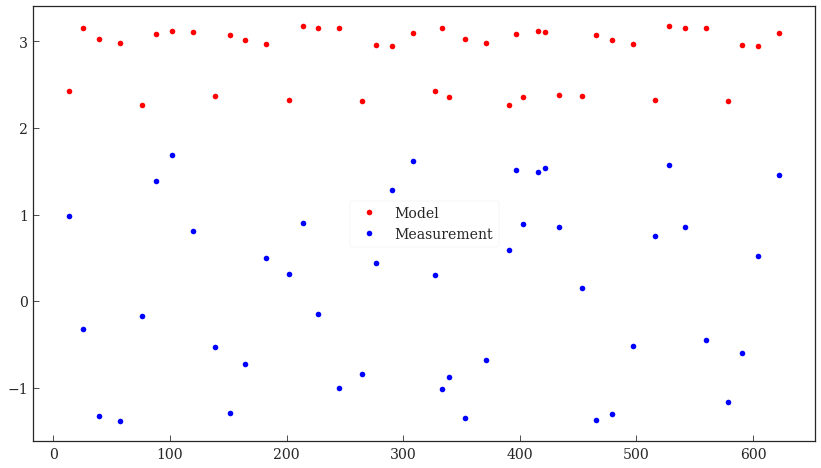

In [35]:
fig, ax = plt.subplots(1,figsize=(14,8))
# ax.plot(optics.S, optics.DISP1,label='Model')
ax.plot(BPM_S, BPM_Dx,'ro', label='Model')
ax.plot(BPM_S, D, 'bo', label='Measurement')
ax.legend(frameon=True)

Text(0.5,0,u'BPM_number')

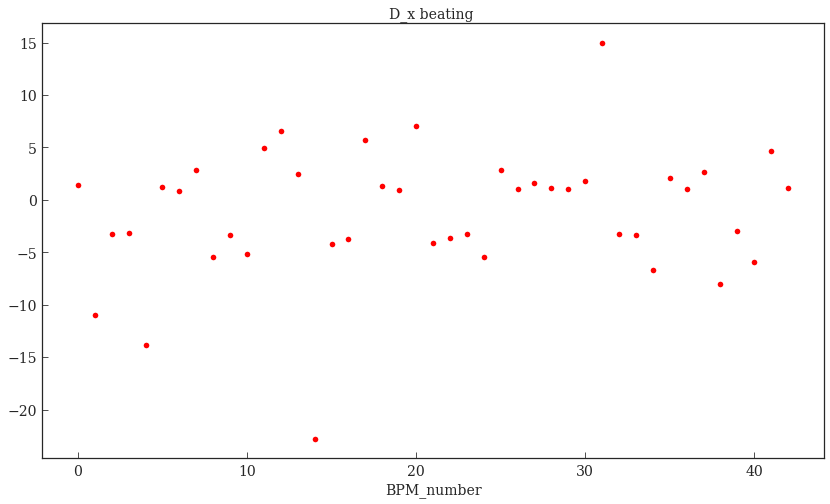

In [36]:
fig, ax = plt.subplots(1,figsize=(14,8))
ax.plot((BPM_Dx-D)/D,'ro', label='Model')
ax.set_title('D_x beating ')
ax.set_xlabel('BPM_number')

Text(0.5,1,u'D_x beating ')

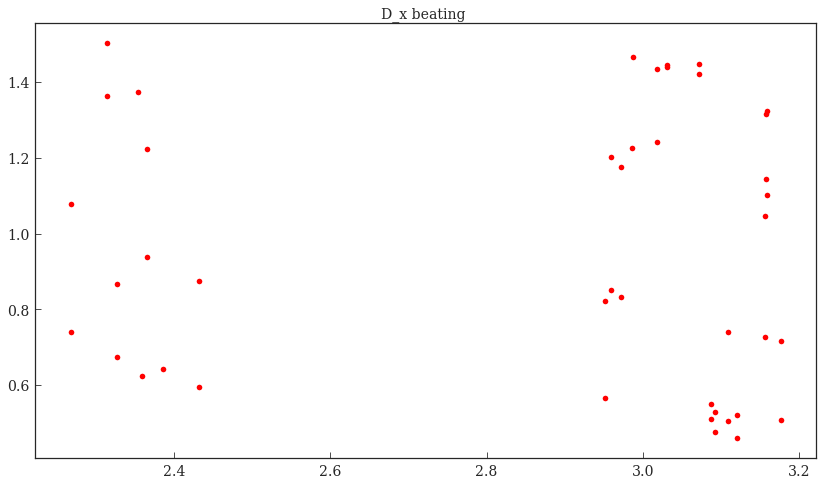

In [37]:
fig, ax = plt.subplots(1,figsize=(14,8))
ax.plot(BPM_Dx,(BPM_Dx-D)/BPM_Dx,'ro', label='Model')
ax.set_title('D_x beating ')


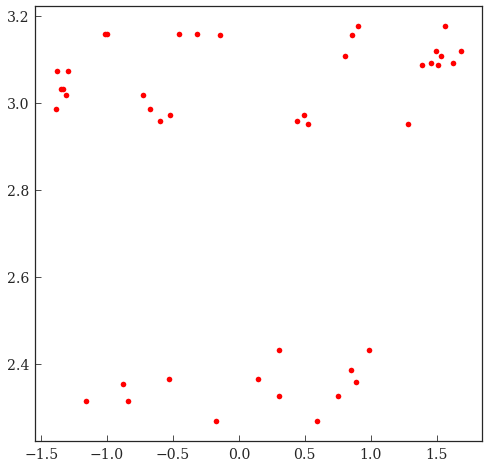

In [38]:
fig, ax = plt.subplots(1,figsize=(8,8))
ax.plot( D, BPM_Dx,'ro', label='Model')


# Data quality plot

(array([ 0.00849325, -0.72616189]), array([  1.84458029e-06,   3.46433606e-01]))


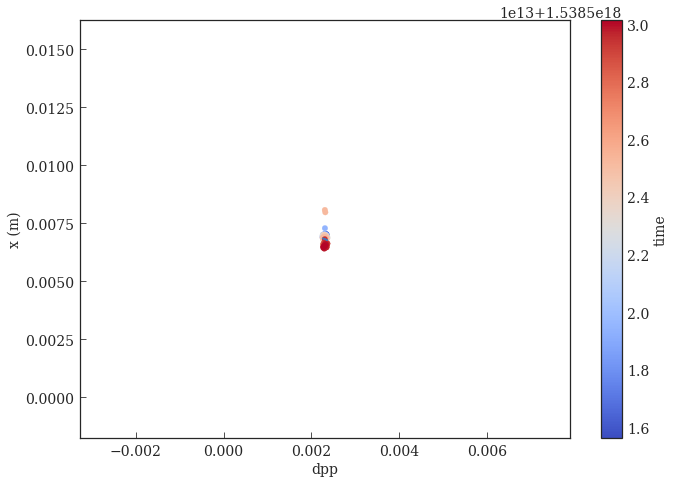

In [40]:
# find correlation parameter 
xx = myDataFrame['dpp']
yy = myDataFrame['x_bpms_mean'].apply(lambda x: x[10])

fig, ax = plt.subplots(1,1,figsize=(10,7))
p1 = ax.scatter(xx, yy, c=myDataFrame.index, cmap=plt.cm.coolwarm)
clb = fig.colorbar(p1)
clb.set_label('time')
ax.set_xlabel('dpp')
ax.set_ylabel('x (m)')

# ax.set_xlim(-3.5e-3,3.5e-3)
# ax.set_ylim(-12e-3,12e-3)

popt, pcov = curve_fit(lin, xx, yy )
print(popt, np.diag(pcov))
plt.plot(xx, lin(xx, *popt))

fig.tight_layout()

In [41]:
# find correlation parameter 
xx = myDataFrame['dpp'].loc[(myDataFrame['Xmrp_f0']<-10) & (myDataFrame['Xmrp_f0']>-17)]
yy = myDataFrame['x_bpms_mean'].loc[(myDataFrame['Xmrp_f0']<-10) & (myDataFrame['Xmrp_f0']>-17)].apply(lambda x: x[10])

fig, ax = plt.subplots(1,1,figsize=(10,7))
p1 = ax.scatter(xx, yy)#, c=myDataFrame.index[:30], cmap=plt.cm.coolwarm)
# clb = fig.colorbar(p1)
# clb.set_label('time')
ax.set_xlabel('dpp')
ax.set_ylabel('x (m)')

ax.set_xlim(-3.5e-3,3.5e-3)
ax.set_ylim(-12e-3,12e-3)

popt, pcov = curve_fit(lin, xx, yy )
print(popt, np.diag(pcov))
plt.plot(xx, lin(xx, *popt))

fig.tight_layout()

KeyError: 'Xmrp_f0'

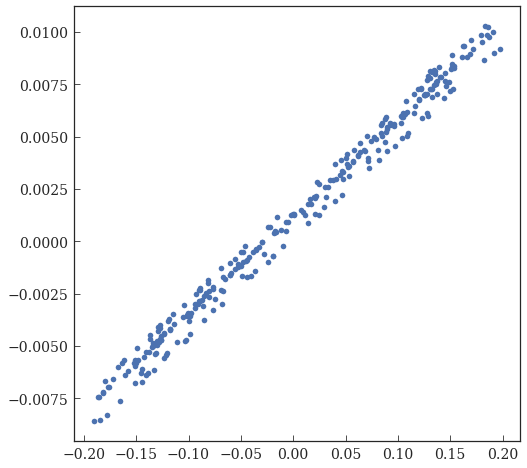

In [68]:
fig, ax = plt.subplots(1,figsize=(8,8))
ax.plot( myDataFrame['f']-myDataFrame['f0'], myDataFrame['x_bpms_mean'].apply(lambda x: x[0]),'o' )


# MRP check

In [42]:
myDataFrame['Xmrp_f'] = myDataFrame['PR_BPM.AcquisitionMean.value.position'].apply(lambda x: np.mean(x[0][770:820]))
myDataFrame['Xmrp_f0'] = myDataFrame['PR_BPM.AcquisitionMean.value.position'].apply(lambda x: np.mean(x[0][620:670]))

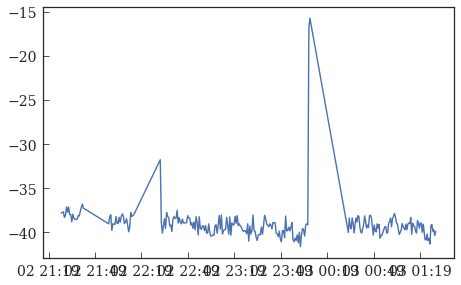

In [43]:
# plt.plot(myDataFrame['Xmrp_f0'].loc[(myDataFrame['Xmrp_f0']<-10) & (myDataFrame['Xmrp_f0']>-17)])
plt.plot(myDataFrame['Xmrp_f0'])

In [44]:
index0 = myDataFrame.loc[(myDataFrame['Xmrp_f0']>-5)][14:].index
index1 = myDataFrame.loc[(myDataFrame['Xmrp_f0']<-38.5) ].index
index2 = myDataFrame.loc[(myDataFrame['Xmrp_f0']<-10) & (myDataFrame['Xmrp_f0']>-17)].index
index3 = myDataFrame.loc[(myDataFrame['Xmrp_f0']<-30) & (myDataFrame['Xmrp_f0']>-38.5)].index

# Calculate the dispersion in the 4 different periods at stable MRP

(array([ 0.00996604, -1.32359865]), array([  5.76991086e-06,   1.08602964e+00]))


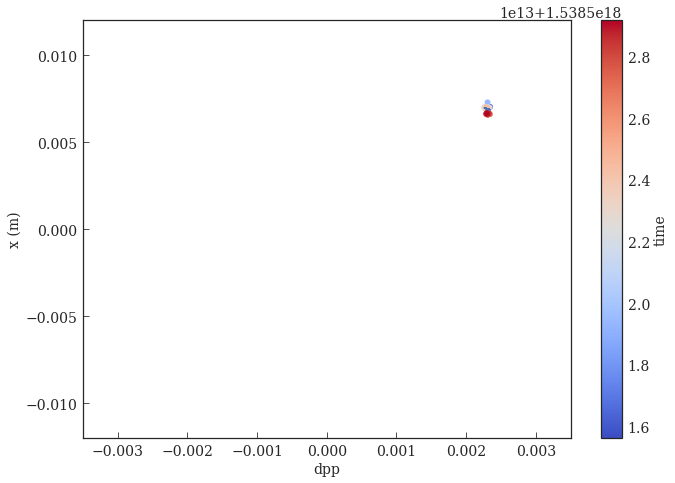

In [45]:
# find correlation parameter 
xx = myDataFrame['dpp'].loc[index3]
yy = myDataFrame['x_bpms_mean'].loc[index3].apply(lambda x: x[10])

fig, ax = plt.subplots(1,1,figsize=(10,7))
p1 = ax.scatter(xx, yy, c=myDataFrame.loc[index3].index, cmap=plt.cm.coolwarm)
clb = fig.colorbar(p1)
clb.set_label('time')
ax.set_xlabel('dpp')
ax.set_ylabel('x (m)')

ax.set_xlim(-3.5e-3,3.5e-3)
ax.set_ylim(-12e-3,12e-3)

popt, pcov = curve_fit(lin, xx, yy )
print(popt, np.diag(pcov))
plt.plot(xx, lin(xx, *popt))

fig.tight_layout()

In [26]:
- compare step and programmed step in the trim
- calculate B field change from the MRP change

SyntaxError: invalid syntax (<ipython-input-26-7d7b8f49a3b5>, line 1)

# Measuring $\Delta$ f using the difference of following shots

In [32]:
myDataFrame['f'].iloc[:10]

2018-09-26 17:08:28.300    436.686525
2018-09-26 17:09:00.700    436.458217
2018-09-26 17:09:33.100    436.640969
2018-09-26 17:10:05.500    436.413671
2018-09-26 17:10:37.900    436.683667
2018-09-26 17:11:10.300    436.414029
2018-09-26 17:11:42.700    436.686197
2018-09-26 17:12:15.100    436.424793
2018-09-26 17:12:47.500    436.674319
2018-09-26 17:13:19.900    436.545512
Name: f, dtype: float64

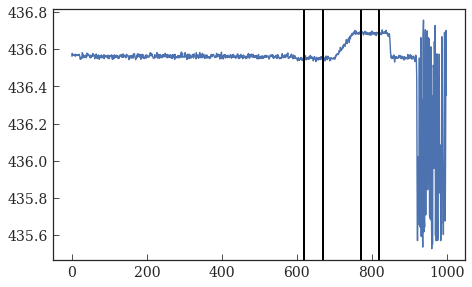

In [33]:
plt.plot(myDataFrame['PA_FREVCL_SD.Samples.value.samples'].iloc[0][:1000])
# f0 averaging interval
plt.axvline(x=620, ymin=0, ymax = 8, linewidth=2, color='k')
plt.axvline(x=670, ymin=0, ymax = 8, linewidth=2, color='k')
# f averaging interval
plt.axvline(x=770, ymin=0, ymax = 8, linewidth=2, color='k')
plt.axvline(x=820, ymin=0, ymax = 8, linewidth=2, color='k')

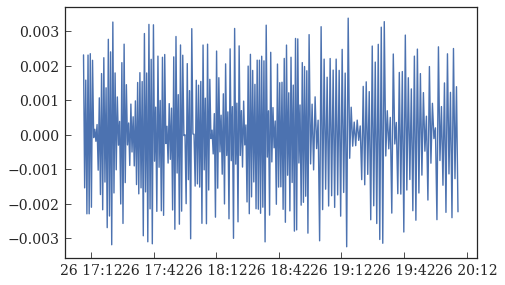

In [35]:
plt.plot(myDataFrame['dpp'])

# Wirescanner check

In [68]:
# Wirescanner sigma
#position data cleanup (sort, get unique values and the idxes) and conversion to mm
myDataFrame['BWS65_position'] = myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[0]*1e-3)
myDataFrame['BWS65_position_idx'] = myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[1])

#instantiate an array object for the result in the frame
myDataFrame['BWS65_data'] = myDataFrame['BWS65_position_idx'].apply(lambda x: np.empty(len(x)))
pos = np.arange(-50, 50, 0.05)

row, col = myDataFrame.shape

for r in xrange(row):
    myDataFrame['BWS65_data'].iloc[r] = np.interp(pos, myDataFrame['BWS65_position'].iloc[r], myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.projDataSet1'].iloc[r][myDataFrame['BWS65_position_idx'].iloc[r]])  
        
#do the fit and get the sigma in mm
myDataFrame['WS65_fit_results_y'] = myDataFrame['BWS65_data'].apply(lambda x: myToolbox.makeGaussianFit_5_parameters(pos,x))
myDataFrame['WS65_sigma_y'] = myDataFrame['WS65_fit_results_y'].apply(lambda x: x[0][-1])

/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [69]:
myDataFrame['WS65_mean_y'] = myDataFrame['WS65_fit_results_y'].apply(lambda x: x[0][-2])

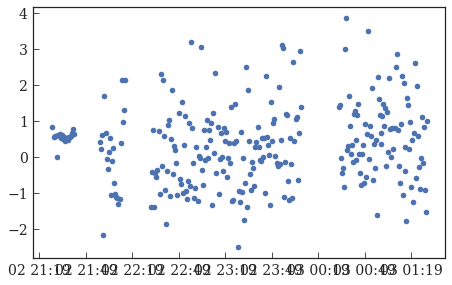

In [71]:
plt.plot(myDataFrame['WS65_mean_y'],'o')

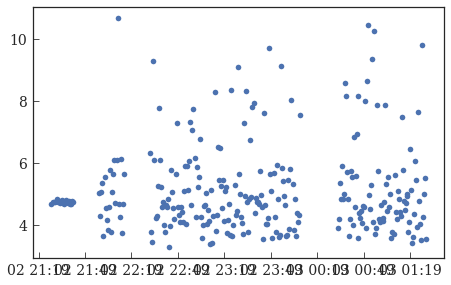

In [73]:
plt.plot(myDataFrame['WS65_sigma_y'],'o')

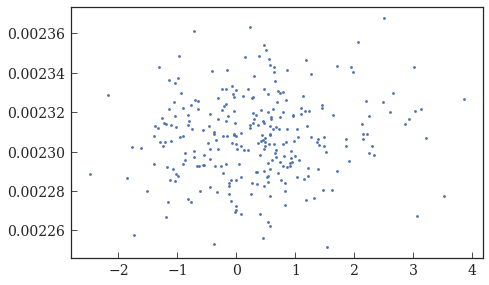

In [79]:
plt.plot(myDataFrame['WS65_mean_y'], myDataFrame['dpp'],'.')